## 1.0 - Libraries

In [65]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Encoding & preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Model selection
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import shap
import joblib
import json
from joblib import dump

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay
)

# Warnings
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

## 2.0 - Loading Data

In [33]:
# Load the processed dataset
df = pd.read_csv('../data/processed/telco_eda_cleaned.csv')

In [34]:
# Check basic info
print(f"Shape: {df.shape}")
df.head()

Shape: (7032, 23)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group,charges_per_month
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0–12,29.850000
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,25–48,55.573529
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,0–12,54.075000
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,25–48,40.905556
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0–12,75.825000


## 3.0 - Feature Selection and Target Definition

In [35]:
# Encode the target variable: Churn (Yes → 1, No → 0)
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

# Drop ID column
if 'customerID' in df.columns:
    df = df.drop('customerID', axis=1)

# Define target (y) and features (X)
y = df['Churn']
X = df.drop('Churn', axis=1)

# Check dimensions
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (7032, 21)
Target shape: (7032,)


## 4.0 - Encoding Categorical Variables

In [36]:
# Identify categorical and numerical columns
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(exclude=['object']).columns.tolist()

print("Categorical features:", categorical_features)
print("Numerical features:", numerical_features)

# Create a ColumnTransformer: OneHot for categorical, passthrough for numerical
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numerical_features)
    ]
)

Categorical features: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'tenure_group']
Numerical features: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'charges_per_month']


## 5.0 - Train/Test Split

In [37]:
# Split the data: 80% train, 20% test, stratified by target
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Confirm the shape
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Churn rate in train: {y_train.mean():.2%}")
print(f"Churn rate in test:  {y_test.mean():.2%}")

X_train shape: (5625, 21)
X_test shape: (1407, 21)
Churn rate in train: 26.58%
Churn rate in test:  26.58%


## 6.0 - Baseline Models

### 6.1 - Logistic Regression

In [38]:
# Create pipeline: preprocessing + model
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Fit the model
logreg_pipeline.fit(X_train, y_train)

# Predict on test set
y_pred = logreg_pipeline.predict(X_test)
y_proba = logreg_pipeline.predict_proba(X_test)[:, 1]

In [39]:
# Evaluation metrics
print("Logistic Regression Performance:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_proba):.4f}")

Logistic Regression Performance:
Accuracy:  0.7932
Precision: 0.6334
Recall:    0.5267
F1 Score:  0.5752
ROC AUC:   0.8346


The model shows good general discrimination (ROC AUC > 0.83), but recall is relatively low. This suggests that many actual churned customers are not being captured. We will now compare this to tree-based models.

### 6.2 - Random Forest

In [40]:
# Pipeline with Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Fit
rf_pipeline.fit(X_train, y_train)

# Predict
y_pred_rf = rf_pipeline.predict(X_test)
y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

In [41]:
# Evaluation
print("Random Forest Performance:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_rf):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_proba_rf):.4f}")

Random Forest Performance:
Accuracy:  0.7861
Precision: 0.6189
Recall:    0.5080
F1 Score:  0.5580
ROC AUC:   0.8207


Compared to logistic regression, the random forest model shows slightly lower performance on all metrics. However, this model may benefit significantly from hyperparameter tuning, which will be addressed in later stages.

### 6.3 - XGBoost

In [42]:
# Pipeline with XGBoost
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=100,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ))
])

# Fit the model
xgb_pipeline.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_pipeline.predict(X_test)
y_proba_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

In [43]:
# Evaluation
print("XGBoost Performance:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_xgb):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_xgb):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_proba_xgb):.4f}")

XGBoost Performance:
Accuracy:  0.7761
Precision: 0.5902
Recall:    0.5160
F1 Score:  0.5506
ROC AUC:   0.8075


Although XGBoost is known for strong performance in structured data problems, it did not outperform logistic regression in this initial test. This is expected without proper hyperparameter tuning, which will be addressed in later steps.

## 7.0 - Model Evaluation

Below is a summary of the baseline performance for all models evaluated:

| Model                 | Accuracy | Precision | Recall | F1 Score | ROC AUC |
|-----------------------|----------|-----------|--------|----------|---------|
| Logistic Regression   | 0.7932   | 0.6334    | 0.5267 | 0.5752   | 0.8346  |
| Random Forest         | 0.7861   | 0.6189    | 0.5080 | 0.5580   | 0.8207  |
| XGBoost               | 0.7761   | 0.5902    | 0.5160 | 0.5506   | 0.8075  |

**Key insights:**
- Logistic Regression outperformed other models in all metrics, including ROC AUC (0.8346).
- Random Forest and XGBoost showed potential but will likely benefit from hyperparameter tuning.
- Given its strong baseline and simplicity, Logistic Regression may serve as a benchmark or production-ready fallback.

## 8.0 - Final Model Selection & Tuning

Use logistic regression as a baseline benchmark.
Only proceed with hyperparameter tuning for random forest.
The goal is to exceed logistic regression's ROC AUC (0.8346) and improve recall and F1 score.

In [44]:
# Define the pipeline again to tune Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define the parameter search space
param_dist = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 5, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['auto', 'sqrt', 'log2']
}

# Define stratified cross-validation
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up the randomized search
random_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_dist,
    n_iter=30,  # Number of combinations to try
    cv=cv_strategy,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit search on training data
random_search.fit(X_train, y_train)

# Print best parameters and best score
print("Best ROC AUC (CV):", random_search.best_score_)
print("Best Parameters:")
print(random_search.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best ROC AUC (CV): 0.8469045324609068
Best Parameters:
{'classifier__n_estimators': 300, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 4, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 10}


In [46]:
# Predict on training set
y_pred_train = best_model.predict(X_train)
y_proba_train = best_model.predict_proba(X_train)[:, 1]

# Evaluate performance on training set
print("Tuned Random Forest on Training Set:")
print(f"Accuracy:  {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Precision: {precision_score(y_train, y_pred_train):.4f}")
print(f"Recall:    {recall_score(y_train, y_pred_train):.4f}")
print(f"F1 Score:  {f1_score(y_train, y_pred_train):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_train, y_proba_train):.4f}")

Tuned Random Forest on Training Set:
Accuracy:  0.8444
Precision: 0.7748
Recall:    0.5846
F1 Score:  0.6664
ROC AUC:   0.9190


In [45]:
# Predict using best estimator on test data
best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_test)
y_proba_best = best_model.predict_proba(X_test)[:, 1]

# Evaluate performance on test set
print("Tuned Random Forest on Test Set:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_best):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_best):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_best):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_best):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_proba_best):.4f}")

Tuned Random Forest on Test Set:
Accuracy:  0.7910
Precision: 0.6429
Recall:    0.4813
F1 Score:  0.5505
ROC AUC:   0.8361


### 8.1 - Threshold Test

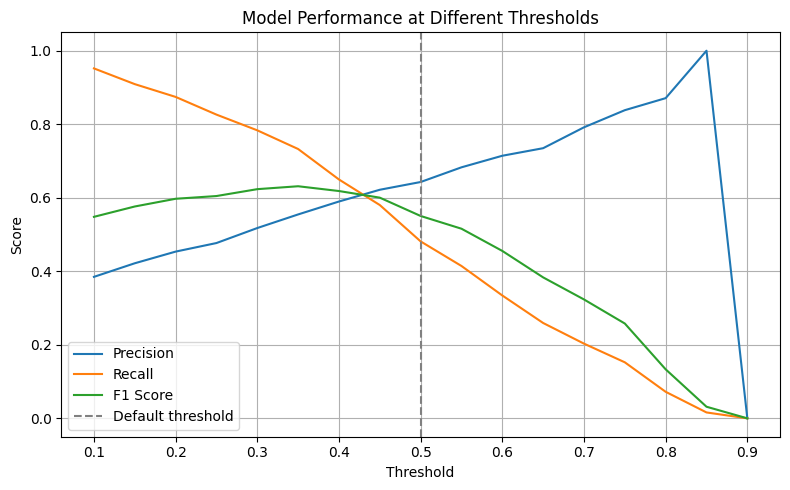

Best F1 Score: 0.6313 at Threshold = 0.35


In [47]:
# Define thresholds to evaluate
thresholds = np.arange(0.1, 0.91, 0.05)

# Store metrics for each threshold
precisions = []
recalls = []
f1s = []

for threshold in thresholds:
    y_pred_thresh = (y_proba_best >= threshold).astype(int)
    precisions.append(precision_score(y_test, y_pred_thresh))
    recalls.append(recall_score(y_test, y_pred_thresh))
    f1s.append(f1_score(y_test, y_pred_thresh))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1 Score')
plt.axvline(0.5, color='gray', linestyle='--', label='Default threshold')
plt.title('Model Performance at Different Thresholds')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Show best threshold by F1
best_idx = np.argmax(f1s)
print(f"Best F1 Score: {f1s[best_idx]:.4f} at Threshold = {thresholds[best_idx]:.2f}")

In [49]:
# Define the chosen threshold
threshold = 0.35

# Predict with threshold on test set
y_pred_test_thresh = (y_proba_best >= threshold).astype(int)

# Predict with threshold on train set
y_proba_train = best_model.predict_proba(X_train)[:, 1]
y_pred_train_thresh = (y_proba_train >= threshold).astype(int)

# Evaluate train set
print("\nTrain Set Metrics (threshold = 0.35):")
print(f"Accuracy:  {accuracy_score(y_train, y_pred_train_thresh):.4f}")
print(f"Precision: {precision_score(y_train, y_pred_train_thresh):.4f}")
print(f"Recall:    {recall_score(y_train, y_pred_train_thresh):.4f}")
print(f"F1 Score:  {f1_score(y_train, y_pred_train_thresh):.4f}")

print("")

# Evaluate test set
print("Test Set Metrics (threshold = 0.35):")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_test_thresh):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_test_thresh):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_test_thresh):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_test_thresh):.4f}")


Train Set Metrics (threshold = 0.35):
Accuracy:  0.8391
Precision: 0.6576
Recall:    0.8234
F1 Score:  0.7312

Test Set Metrics (threshold = 0.35):
Accuracy:  0.7726
Precision: 0.5547
Recall:    0.7326
F1 Score:  0.6313


After training and comparing multiple models, the Random Forest classifier with hyperparameter tuning outperformed the baseline logistic regression in terms of ROC AUC, reaching:

- **ROC AUC (Test):** 0.8361
- **F1 Score (Test):** 0.5505 (initial threshold of 0.50)

However, the model initially showed signs of **moderate overfitting**, with a training ROC AUC of 0.9190 and noticeably higher F1 and recall scores compared to the test set. To mitigate this and improve real-world performance, we applied a **custom classification threshold of 0.35**, instead of the default 0.50.

This decision threshold adjustment significantly increased recall and overall balance:

- **Recall (Test):** increased from 0.4813 → **0.7326**
- **F1 Score (Test):** increased from 0.5505 → **0.6313**
- **Train/Test gap in performance was reduced**, indicating improved generalization and reduced overfitting impact

The final model demonstrates strong potential for real-world deployment in churn prediction scenarios, particularly where **recall is critical** — such as identifying customers at risk of leaving the service.

## 9.0 - Feature Importance and SHAP

In [50]:
# Access trained model and preprocessor
rf_model = best_model.named_steps['classifier']
encoder = best_model.named_steps['preprocessor'].named_transformers_['cat']
encoded_cols = encoder.get_feature_names_out(categorical_features)

# Combine encoded categorical + numerical column names
feature_names = np.concatenate([encoded_cols, numerical_features])

# Get feature importances
importances = rf_model.feature_importances_

# Create DataFrame
feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display top 15 features
feat_imp.head(15)

,Feature,Importance
31,tenure,0.164831
33,TotalCharges,0.139699
32,MonthlyCharges,0.085152
34,charges_per_month,0.082257
6,InternetService_Fiber optic,0.069740
21,Contract_Two year,0.064132
24,PaymentMethod_Electronic check,0.061579
20,Contract_One year,0.033472
9,OnlineSecurity_Yes,0.032373
15,TechSupport_Yes,0.025986


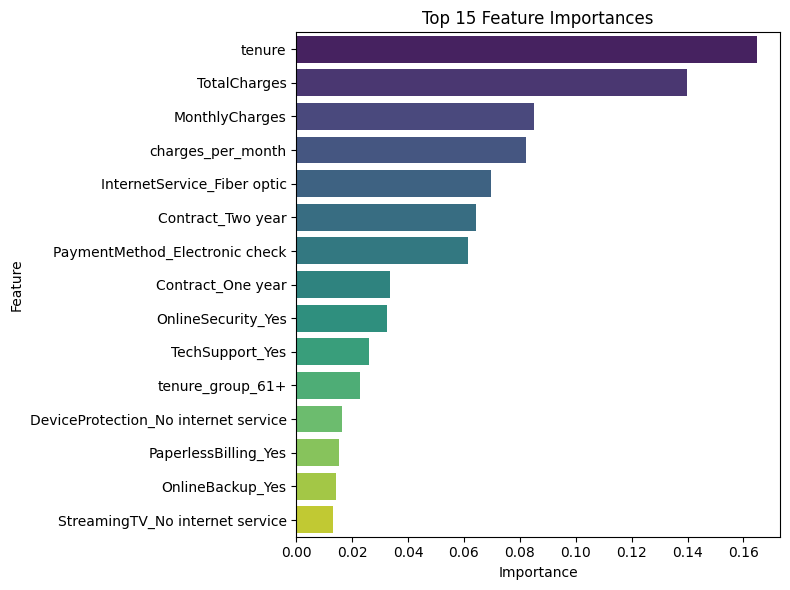

In [51]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp.head(15), palette='viridis')
plt.title('Top 15 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

The final model confirms the expected behavioral drivers of churn:

- **Tenure and TotalCharges** are the strongest predictors, highlighting that long-term customers are less likely to churn.
- **MonthlyCharges** and **charges_per_month** emphasize the influence of expensive plans.
- Customers with **fiber optic internet**, **electronic check payments**, and **short-term contracts** are more prone to churn.
- Optional services such as **online security** and **technical support** also contribute to retention likelihood.

This validates the interpretability of the model and ensures that its decisions are aligned with business intuition.

## 10.0 - Save Model

In [66]:
# Save the trained model pipeline
joblib.dump(best_model, '../models/random_forest_model.pkl')

# Save the chosen threshold (0.35, por exemplo)
with open('../models/threshold.json', 'w') as f:
    json.dump({'threshold': 0.35}, f)

# Save X_test to use it in test script
dump(X_test, '../models/X_test_sample.joblib')

['../models/X_test_sample.joblib']

To conclude the modeling phase, we save both the final model and the optimal threshold chosen based on F1 Score analysis.

- The model is saved using `joblib` for future reuse or deployment.
- The threshold (0.35) is stored in a separate JSON file, to be used in prediction pipelines.

These artifacts ensure reproducibility and portability of the churn prediction solution.